# Placement Prediction Dataset

Este dataset se centra en la predicción de la empleabilidad de estudiantes en función de su desempeño académico, experiencia práctica y habilidades blandas. Contiene información sobre calificaciones, participación en pasantías, proyectos, certificaciones y actividades extracurriculares, así como puntajes en pruebas de aptitud y entrenamientos específicos para la colocación laboral. Su objetivo es analizar qué factores influyen en la posibilidad de que un estudiante consiga un empleo tras finalizar sus estudios.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
np.random.seed(21)

En primer lugar vamos a cargar los archivos, este codigo permitira que descarguemos nuestro dataset desde la pagina de kaggle en donde se encuentra alojado

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielyaruro20","key":"c581446a869abf201c7abaf71de3e330"}'}

In [ ]:
import os
import zipfile

# Mover kaggle.json a la ubicación correcta
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Asegurar permisos correctos

In [ ]:
!kaggle datasets download -d ruchikakumbhar/placement-prediction-dataset
with zipfile.ZipFile("placement-prediction-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("placement_data")

Dataset URL: https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset
License(s): CC0-1.0


## Carga y exploracion del dataset

De aqui podemos ver como son los tipos de datos que tendremos en nuestro dataset, tenemos desde booleanos, enteros, y algunos valores continuos

Vamos a ajustar el indice de nuestro dataset, de modo que el StudentID sea nuestro indice

In [ ]:
import pandas as pd

df = pd.read_csv("/content/placement_data/placementdata.csv", index_col="StudentID")
df.head()

,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
StudentID,,,,,,,,,,,
1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


De aqui podremos ver alguna informacion de nuestro dataset como son las columnas y ver que tantos valores nulos tiene, para este caso tendremos 10000 datos y todos los datos estan completos por lo que no tenemos valores nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CGPA                       10000 non-null  float64
 1   Internships                10000 non-null  int64  
 2   Projects                   10000 non-null  int64  
 3   Workshops/Certifications   10000 non-null  int64  
 4   AptitudeTestScore          10000 non-null  int64  
 5   SoftSkillsRating           10000 non-null  float64
 6   ExtracurricularActivities  10000 non-null  object 
 7   PlacementTraining          10000 non-null  object 
 8   SSC_Marks                  10000 non-null  int64  
 9   HSC_Marks                  10000 non-null  int64  
 10  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 937.5+ KB


Podemos ver aqui algunas estadisticas de nuestro dataset para las variables numericas, para poder ubicar los datos que tenenmos y tener una idea clara de los valores posibles que pueden haber en cada columna

In [ ]:
df.describe()

,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,SSC_Marks,HSC_Marks
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.698010,1.049200,2.026600,1.013200,79.449900,4.323960,69.159400,74.501500
std,0.640131,0.665901,0.867968,0.904272,8.159997,0.411622,10.430459,8.919527
min,6.500000,0.000000,0.000000,0.000000,60.000000,3.000000,55.000000,57.000000
25%,7.400000,1.000000,1.000000,0.000000,73.000000,4.000000,59.000000,67.000000
50%,7.700000,1.000000,2.000000,1.000000,80.000000,4.400000,70.000000,73.000000
75%,8.200000,1.000000,3.000000,2.000000,87.000000,4.700000,78.000000,83.000000
max,9.100000,2.000000,3.000000,3.000000,90.000000,4.800000,90.000000,88.000000


Aqui podremos ver un poco de la descripcion de lo que son los valores que estan como cadenas o que no son numericos para poder observar como estan distribuidos esos datos en nuestro dataset

In [ ]:
df.describe(include="object")

,ExtracurricularActivities,PlacementTraining,PlacementStatus
count,10000,10000,10000
unique,2,2,2
top,Yes,Yes,NotPlaced
freq,5854,7318,5803


Como podemos observar los valores que tenemos como cadenas de datos no son mas que valores booleanos pero en formato String, por ende lo que haremos sera esos datos parsearlos a formato boolean para un mejor manejo de estos datos a futuro

Usaremos 1 para los valores "Yes"

Usaremos 0 para los valores "No"

In [ ]:
df_original = df.copy()

In [ ]:
df["ExtracurricularActivities"] = df["ExtracurricularActivities"].apply(lambda x: 1 if x == "Yes" else 0)
df["PlacementTraining"] = df["PlacementTraining"].apply(lambda x: 1 if x == "Yes" else 0)
df["PlacementStatus"] = df["PlacementStatus"].apply(lambda x: 1 if x == "Placed" else 0)

Vemos ahora si las estadisticas de todas las 11 columnas de nuestro dataset

In [ ]:
df.describe()

,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.698010,1.049200,2.026600,1.013200,79.449900,4.323960,0.585400,0.731800,69.159400,74.501500,0.419700
std,0.640131,0.665901,0.867968,0.904272,8.159997,0.411622,0.492677,0.443044,10.430459,8.919527,0.493534
min,6.500000,0.000000,0.000000,0.000000,60.000000,3.000000,0.000000,0.000000,55.000000,57.000000,0.000000
25%,7.400000,1.000000,1.000000,0.000000,73.000000,4.000000,0.000000,0.000000,59.000000,67.000000,0.000000
50%,7.700000,1.000000,2.000000,1.000000,80.000000,4.400000,1.000000,1.000000,70.000000,73.000000,0.000000
75%,8.200000,1.000000,3.000000,2.000000,87.000000,4.700000,1.000000,1.000000,78.000000,83.000000,1.000000
max,9.100000,2.000000,3.000000,3.000000,90.000000,4.800000,1.000000,1.000000,90.000000,88.000000,1.000000


## Exploracion grafica del dataset

En primer lugar veremos como estan relacionadas nuestras variables y ver que concluciones podemos sacar de correlaciones en nuestro dataset, para ello nos ayudaremos de un pairplot() y tambien de una matriz de correlacion

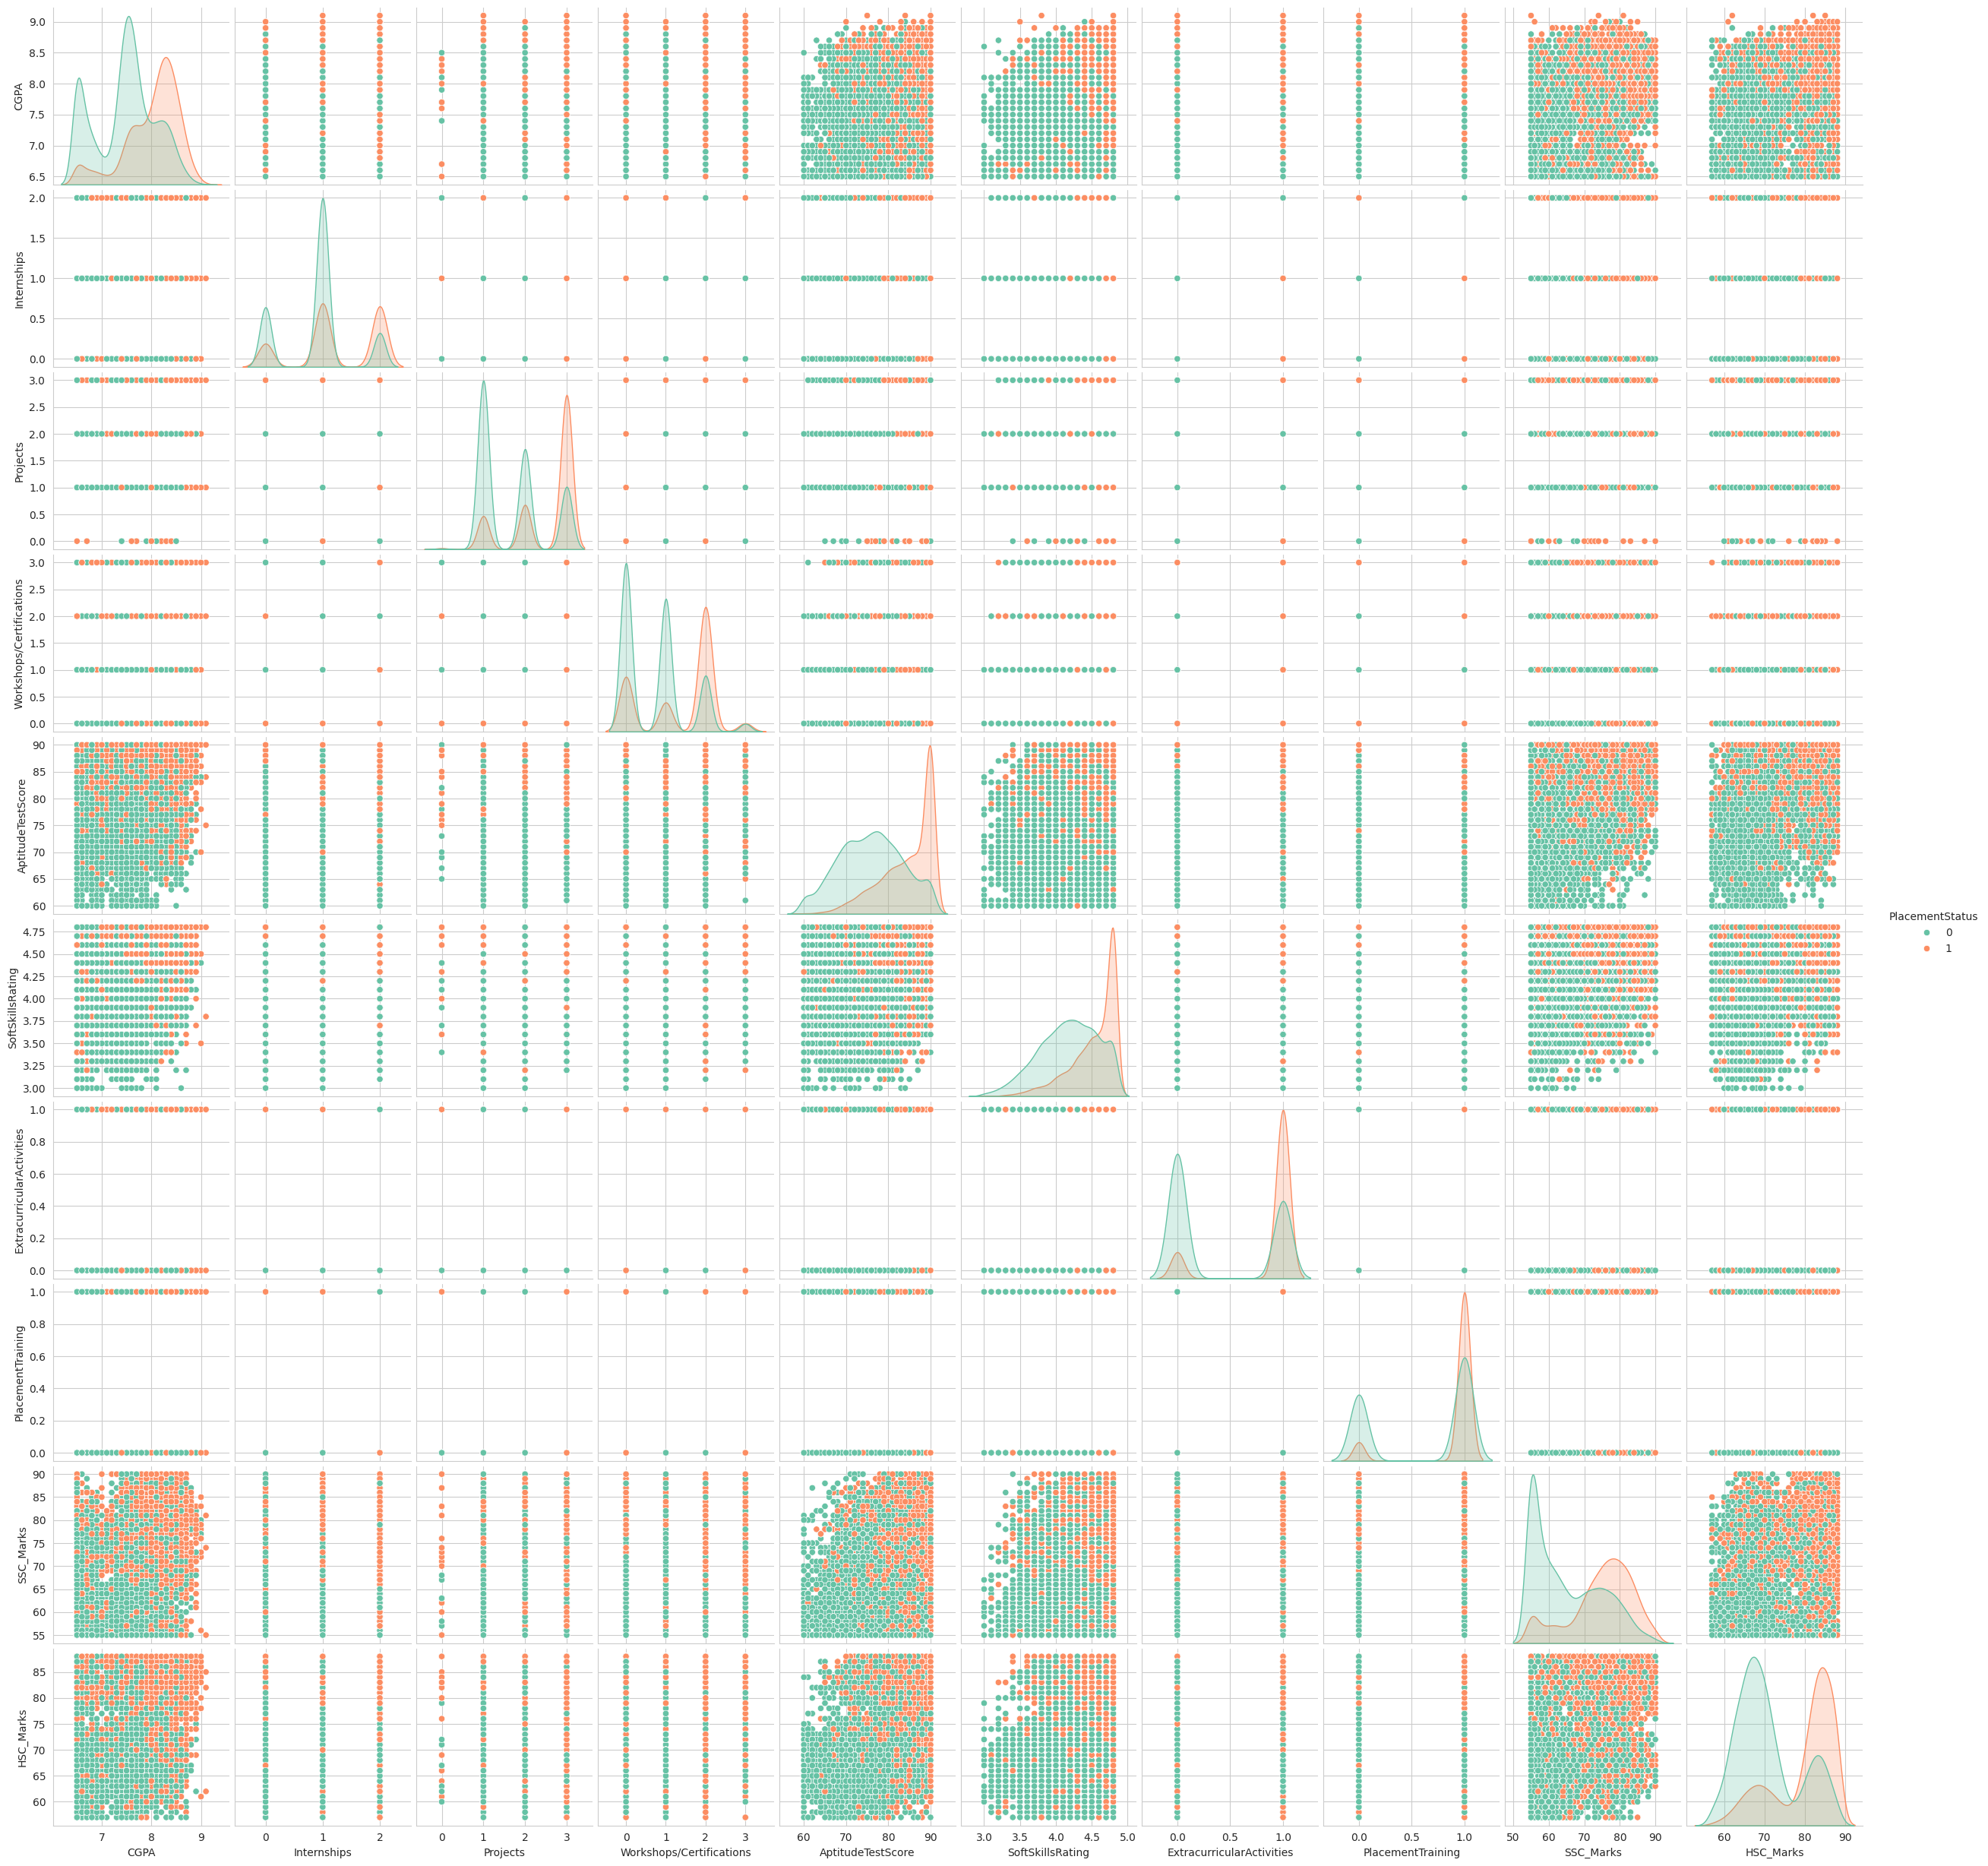

In [ ]:
#Pairplot entre todos nuestros datos para ver las respectivas correlaciones
sns.pairplot(df, hue="PlacementStatus", palette="Set2", diag_kind="kde")

A simpe vista de la grafica podemos ver que no se observa facilmente alguna correlacion entre las variables que tenemos, algo a destacar es que el color verde y naranja en las graficas corresponde a los valores booleanos sobre si un estudiante fue ubicado en un trabajo o no, sin embargo comprobemos la no existencia de correlacion entre las variables con una matriz de correlaciones

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CGPA                       10000 non-null  float64
 1   Internships                10000 non-null  int64  
 2   Projects                   10000 non-null  int64  
 3   Workshops/Certifications   10000 non-null  int64  
 4   AptitudeTestScore          10000 non-null  int64  
 5   SoftSkillsRating           10000 non-null  float64
 6   ExtracurricularActivities  10000 non-null  int64  
 7   PlacementTraining          10000 non-null  int64  
 8   SSC_Marks                  10000 non-null  int64  
 9   HSC_Marks                  10000 non-null  int64  
 10  PlacementStatus            10000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 937.5 KB


<Axes: >

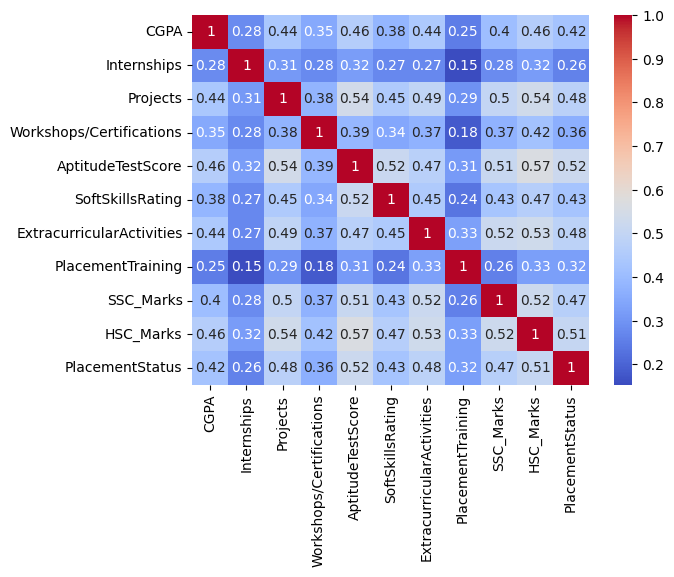

In [ ]:
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm") #Mapa de calor de las correlaciones entre los datos

Esta claro con nuestra grafica de calor de las correlaciones que no existe una fuerte correlacion entre alguna de nuestras variables

Vamos a explorar el conjunto de datos que tenemos, para poder ver la distribucion de los datos de todas las columnas

- **Columna CGPA**

Como vimos en el metodo describe es una columna que contiene valores continuos al parecer que van de 0 a 10, correspondientes al CGPA de cada estudiante del dataset, por ende el grafico que podria darnos mayor detalle es un histplot

<Axes: xlabel='CGPA', ylabel='Count'>

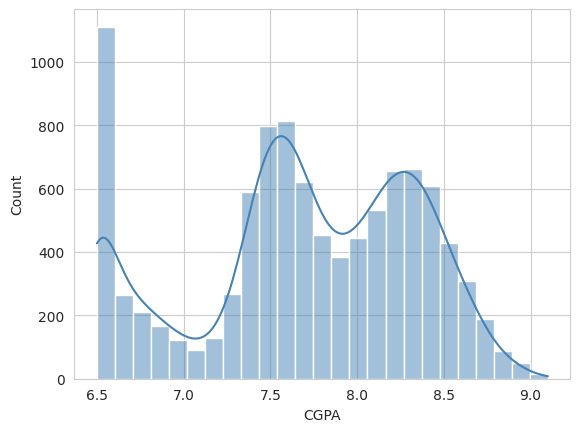

In [ ]:
sns.set_style("whitegrid")
sns.histplot(df, x="CGPA", bins=25, kde=True, color="steelblue")

En esta grafica podemos observar que los CGPA que tienen la mayoria de los estudiantes es de 6.5, tambien estan aproximademente entre 8.3-8.5, y tambien entre 7.3 y 7.7, no sigue una distribucion muy clara

- **Columna Internships**

Estos datos representan la cantidad de interships que han hecho los estudiantes, ahora el maximo valor que encontramos son hasta 2 interships de varios estudiantes, y el minimo valor es 0, es decir tendremos solo 3 categorias para este tipo de dato

<Axes: xlabel='Internships', ylabel='count'>

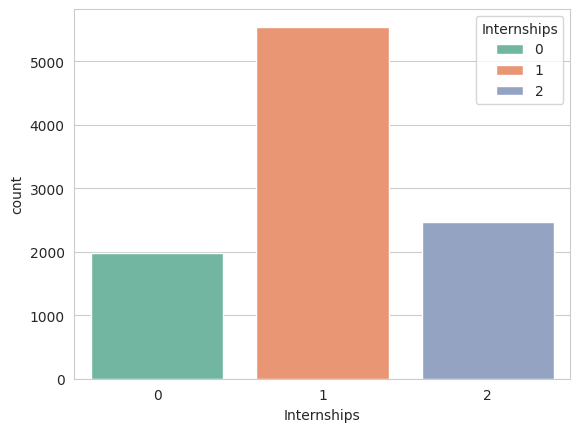

In [ ]:
sns.countplot(x="Internships", data=df, palette="Set2", hue="Internships")

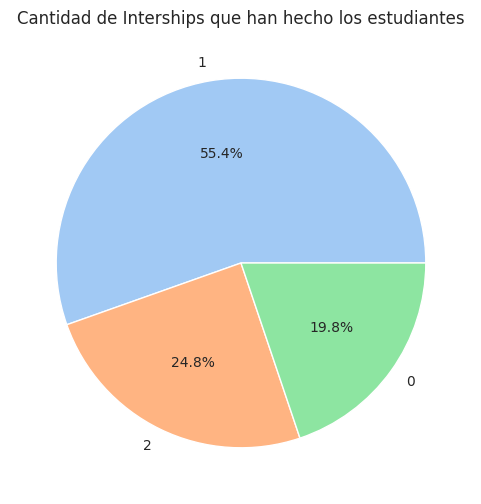

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.pie(df["Internships"].value_counts(), labels=df["Internships"].value_counts().index, autopct="%1.1f%%")
plt.title("Cantidad de Interships que han hecho los estudiantes")
plt.show()

El insight que logramos capturar de la grafica es que la mayoria de los estudiantes se postulan a un primer trabajo con al menos 1 internship realizado

- **Columna Projects**

Esta columna representa la cantidad de proyectos que han hecho los estudiantes antes de explorar su primer trabajo, como vemos se podria considerar una variable categorica por ende las graficas que mejor quedan serian countplot o un pieplot

In [ ]:
df["Projects"].value_counts()

,count
Projects,
3,3873
1,3547
2,2550
0,30


<Axes: xlabel='Projects', ylabel='count'>

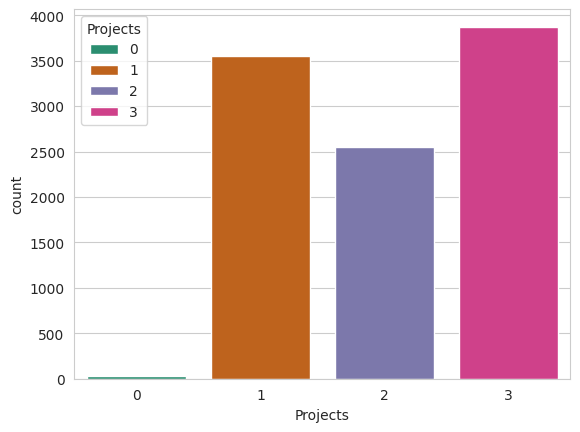

In [ ]:
sns.countplot(x="Projects", data=df, palette="Dark2", hue="Projects")

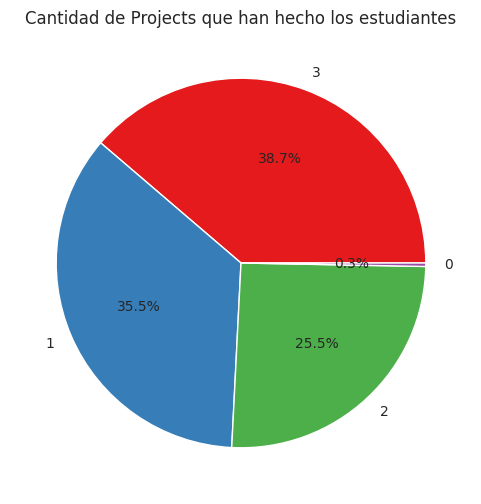

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
sns.set_palette("Set1")
plt.pie(df["Projects"].value_counts(), labels=df["Projects"].value_counts().index, autopct="%1.1f%%")
plt.title("Cantidad de Projects que han hecho los estudiantes")
plt.show()

Observando las graficos podemos notar que la mayoria de estudiantes cuenta con 3 proyectos o unos 2 proyectos a la hora de lanzarse a su primer trabajo

- **Columna Workshops/Certifications**

Esta columna corresponde a el numero de workshops/certificaciones de los estudiantes que se postularon para una colocacion

In [ ]:
df["Workshops/Certifications"].value_counts()

,count
Workshops/Certifications,
0,3739
2,3303
1,2674
3,284


Vamos a usar un grafico de barras apiladas teniendo en cuenta nuestra variable objetivo en este caso placement status donde cada color representara si ese estudiante fue asignado o no

In [ ]:
piv_table = df.groupby(["Workshops/Certifications", "PlacementStatus"]).size().unstack()

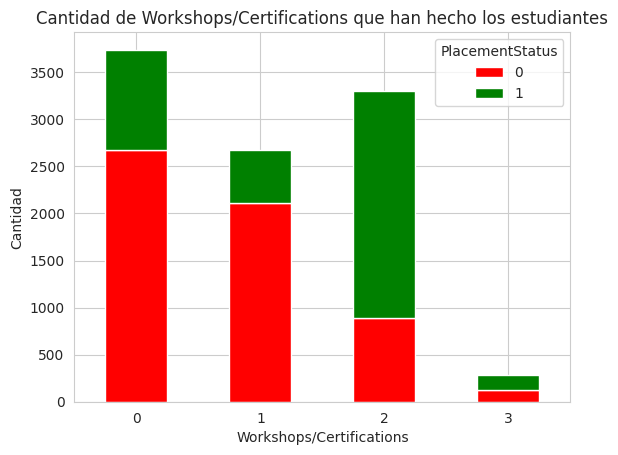

In [ ]:
piv_table.plot(kind="bar", stacked=True, color=["red", "green"]);
plt.title("Cantidad de Workshops/Certifications que han hecho los estudiantes");
plt.xlabel("Workshops/Certifications");
plt.ylabel("Cantidad");
plt.xticks(rotation=0);

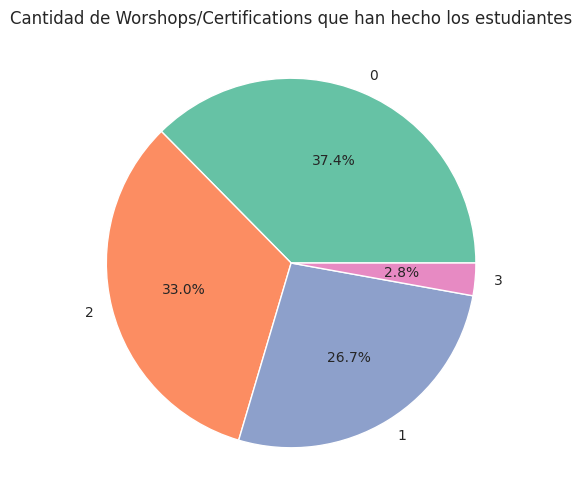

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.pie(df["Workshops/Certifications"].value_counts(), labels=df["Workshops/Certifications"].value_counts().index, autopct="%1.1f%%")
plt.title("Cantidad de Worshops/Certifications que han hecho los estudiantes")
plt.show()

Parece haber una ligera correlacion positiva entre la cantidad de workshops/certificaciones y la posibilidad de conseguir un trabajo. Los estudiantes con mas certificaciones tienen mas probabilidades de ser colocados en comparacion con los que no tienen ninguna. Es mas probable si tienen al menos dos workshops/certifications

- **Columna AptitudeTestScore**

Esta columna representa la calificacion que obtuvieron los estudiantes en el test de actitud que hace la empresa o organizacion para asignar a los estudiantes

Como pudimos ver esta columna tiene valores de calificacion del uno al 100, un histplot nos ayudara a ver como fue el resultado de los estudiantes en general

<Axes: xlabel='AptitudeTestScore', ylabel='Count'>

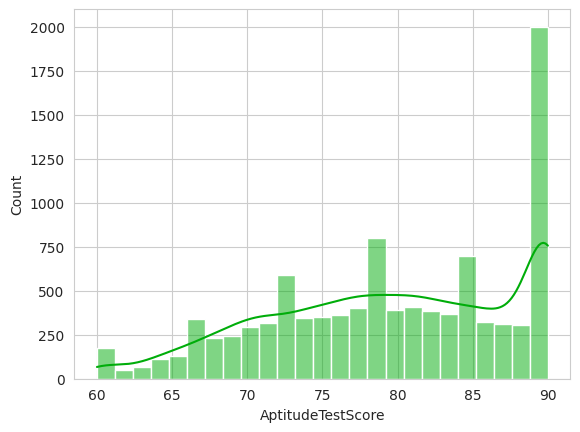

In [ ]:
sns.histplot(df, x="AptitudeTestScore", bins=25, kde=True, color="#00ad0a")

Los datos revelan que a la mayoria de los estudiantes les fue bastante bien en el test de aptitud mostrando la mayoria de calificaciones entre 90 y 100 aproximadamente

Veamos que tanto influye estos datos con la variable objetivo usando graficos como boxplot o violinplot

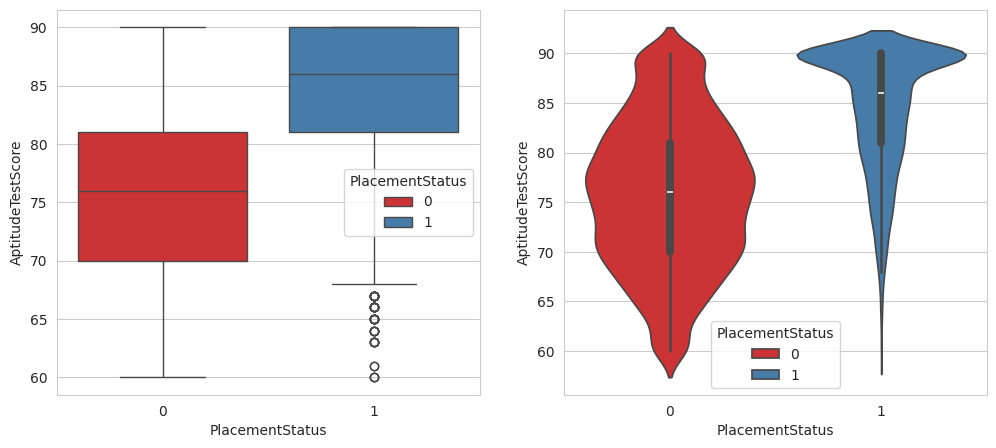

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="PlacementStatus", y="AptitudeTestScore", data=df, ax=axes[0], hue="PlacementStatus", palette="Set1")
sns.violinplot(x="PlacementStatus", y="AptitudeTestScore", data=df, ax=axes[1], hue="PlacementStatus", palette="Set1")
plt.show()

Observando este par de graficas podemos resaltar que precisamente la mayoria de estudiantes que logran ser colocados obtienen un test de aptitud con una buena calificacion normalmente mayor que 80, sin embargo viendo los outliers podemos notar que no todos los que tienen una baja calificacion no logran ser colocados

- **Columna SoftSkillsRating**

Representa las calificaciones en habilidades blandas como la comunicación, una aptitud clave en la inserción laboral y otros ámbitos. Los valores son continuos, entre 3.00 y 4.80.

El histograma muestra su distribución con 19 intervalos, destacando una mayor concentración en las calificaciones más altas.

<Axes: xlabel='SoftSkillsRating', ylabel='Count'>

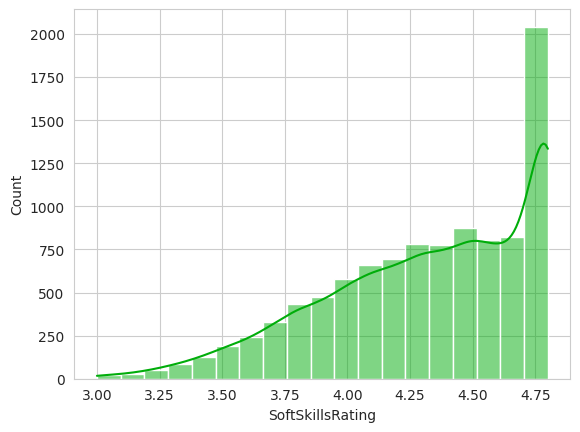

In [ ]:
sns.histplot(df, x="SoftSkillsRating", bins=19, kde=True, color="#00ad0a")

- **Columna ExtracurricularActivities**

Indica si el estudiante ha participado en actividades extracurriculares. Es un dato binario: Sí (1) o No (0).

El gráfico de torta muestra la proporción de estudiantes en cada categoría.

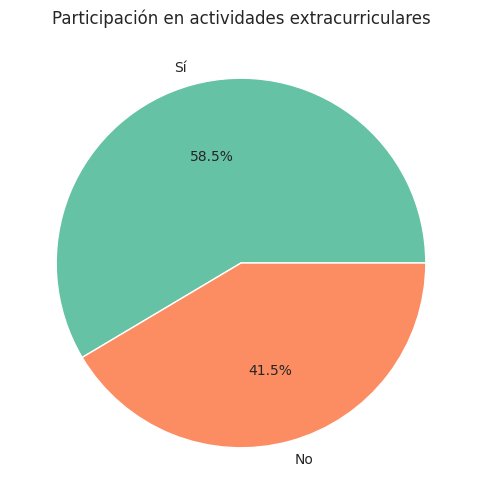

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
sns.set_palette("Set2")
counts = df["ExtracurricularActivities"].value_counts()
labels = ['Sí', 'No']
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.title("Participación en actividades extracurriculares")
plt.show()

- **Columna PlacementTraining**

Este dato binario indica si los estudiantes han recibido capacitación para colocación laboral (1: Sí, 0: No). El gráfico de torta muestra la proporción de estudiantes que han participado en esta capacitación, la cual es proporcionada por la universidad para ayudarlos a destacar en el proceso de colocación laboral.

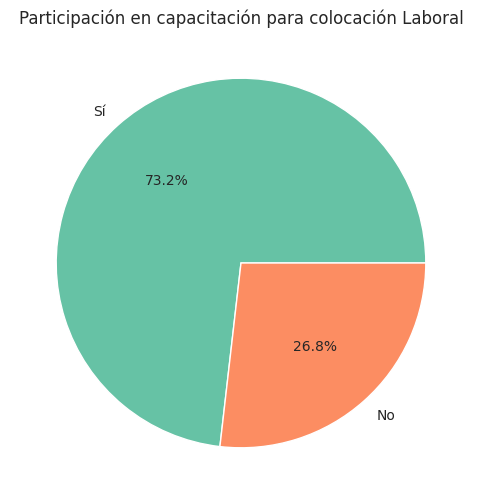

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
sns.set_palette("Set2")
counts = df["PlacementTraining"].value_counts()
labels = ['Sí', 'No']
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.title("Participación en capacitación para colocación Laboral")
plt.show()

- **Columna SSC_Marks**

Dato númerico que representa las calificaciones obtenidas por el estudiante en la educación secundaria, reflejando el rendimiento académico del estudiante en esta etapa. Mediante un histograma observamos la distribución de dichas calificaciones, mostrando cómo se agrupan los valores, observando una concentracion en las calificaciones más bajas.


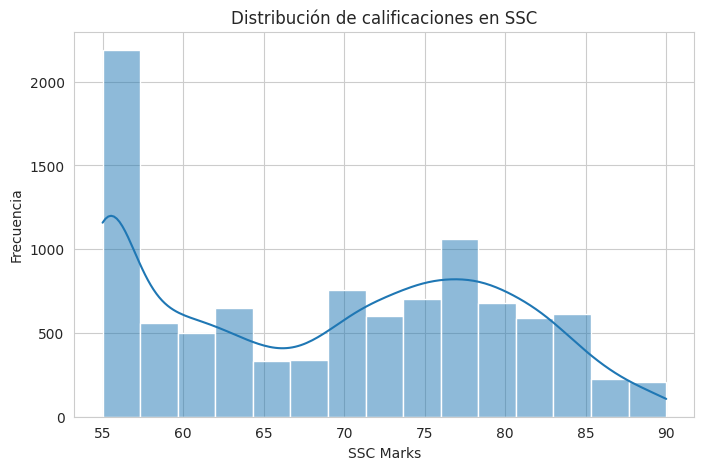

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['SSC_Marks'], bins=15, kde=True, color='#1f77b4')
plt.xlabel("SSC Marks")
plt.ylabel("Frecuencia")
plt.title("Distribución de calificaciones en SSC")
plt.show()

- **Columna HSC_Marks**

Dato númerico que epresenta las calificaciones obtenidas en la educación preuniversitaria, reflejando el rendimiento académico del estudiante en esta etapa.
Se hace uso de un histograma para poder observar la distribución de dichas calificaciones, lo que nos permite ver las concentraciones de datos o posibles picos.



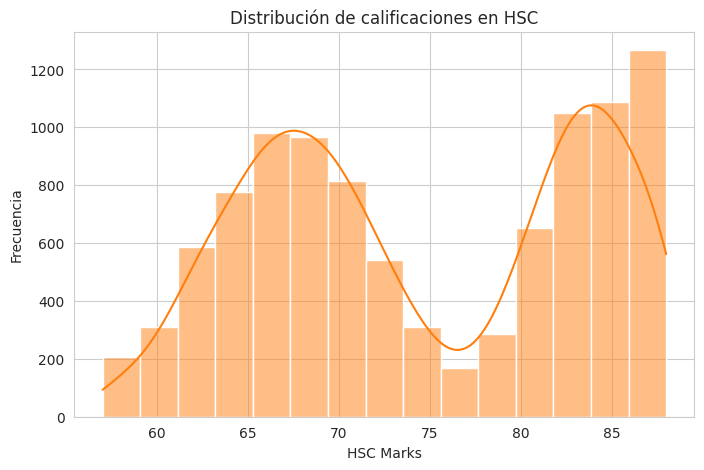

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['HSC_Marks'], bins=15, kde=True, color='#ff7f0e')
plt.xlabel("HSC Marks")
plt.ylabel("Frecuencia")
plt.title("Distribución de calificaciones en HSC")
plt.show()

- **Columna PlacementStatus**

Este dato binario con los valores Placed(1) y Not Placed(0) indica si el estudiante fue colocado en un empleo después de completar su educación. Se utiliza un gráfico de torta que nos permite visualizar de manera clara qué porcentaje de estudiantes ha conseguido empleo y cuál no.

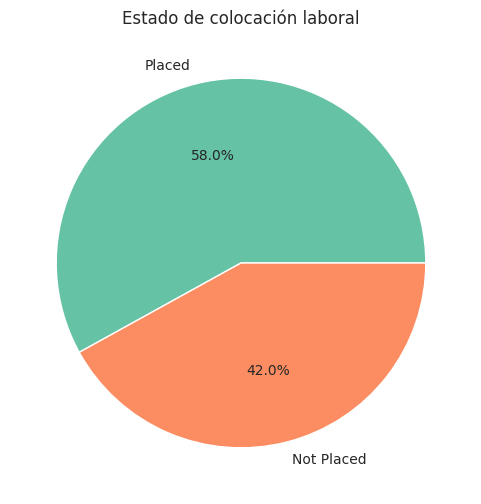

In [ ]:
plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
sns.set_palette("Set2")
counts = df['PlacementStatus'].value_counts()
labels = ['Placed', 'Not Placed']
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.title("Estado de colocación laboral")
plt.show()

# Machine Learning

## Classification Placement Status

Este campo (Placement Status) indica si un estudiante logró o no conseguir un trabajo después del proceso de reclutamiento universitario. Los valores típicos de esta columna son:

"Placed" → El estudiante fue contratado por una empresa.

"Not Placed" → El estudiante no consiguió un empleo durante el proceso de colocación.

Esta variable vamos a usarla como nuestra variable objetivo (ground truth)  para predecir si un estudiante tendrá éxito en colocarse laboralmente en función de sus características académicas, habilidades, experiencia, etc.

Haremos nuestro primer modelo basandonos en variables que estan mas correlacionadas con el ground truth las cuales son:

-
-
-

In [ ]:
#Columnas mas relevantes para PlacementStatus
columnas_relevantes = ["CGPA", "Projects","ExtracurricularActivities", "AptitudeTestScore", "SSC_Marks", "HSC_Marks"]

In [ ]:
X = df[columnas_relevantes]
y = df["PlacementStatus"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## ESTIMADORES

### Sin parametros

In [ ]:
#@title Desicion Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7245


In [ ]:
#@title Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.772


In [ ]:
#@title Support Vector Machines (SVC Classificator)
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.776


### Con parámetros

In [ ]:
#@title **code** learning curve
def show_curve(est):
    means, stds = [], []
    nfolds_range = range(2,10)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(est, X, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

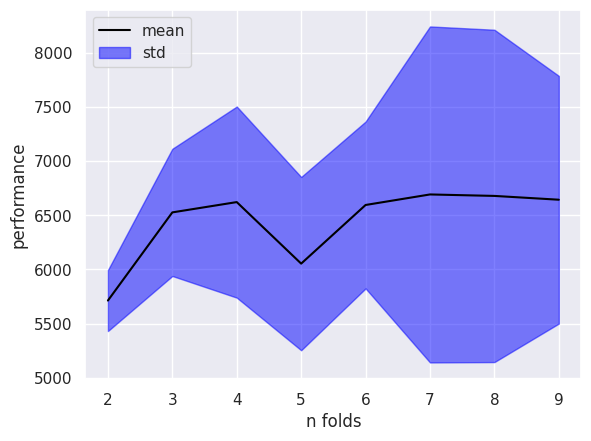

In [ ]:
#@title **code** using DTR

from sklearn.model_selection import cross_val_score
show_curve(DecisionTreeRegressor())

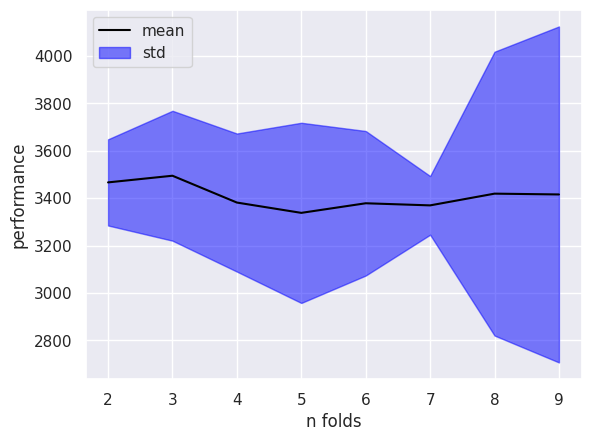

In [ ]:
#@title **code** using RFR
from sklearn.ensemble import RandomForestRegressor
show_curve(RandomForestRegressor())

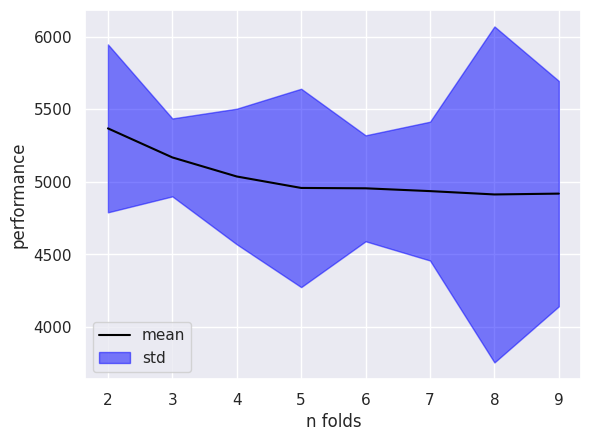

In [ ]:
#@title **code student**
from sklearn.svm import SVR
show_curve(SVR())